In [1]:
import relative_imports
import torch
from matplotlib import pyplot as plt

In [2]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [3]:
device = torch.device("cuda:3")

In [4]:
def get_ndvi(np_rgbi_image):
    if np_rgbi_image.dtype == np.uint16:
        np_rgbi_image = np_rgbi_image.astype(np.int32)
    return (np_rgbi_image[-1] - np_rgbi_image[0]) / (np_rgbi_image[-1] + np_rgbi_image[0] + np.finfo(np.float32).eps)

# Load dataset manager

In [5]:
from spatiotemporal.SEN12MSCRTS import DatasetManager
from spatiotemporal.mods import ZeroPixelsS2, CategoricalCloudMaps, CloudfreeArea
import pandas as pd
from tqdm import tqdm

In [6]:
root_dir = '/LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRTS'
cloud_maps_dir = "/LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRTS_cloud_maps"
dataset_manager = DatasetManager(
    root_dir=root_dir,
    cloud_maps_dir=cloud_maps_dir,
    cloud_probability_threshold=0.35
)
dataset_manager.load_from_file()

In [7]:
ZeroPixelsS2(dataset_manager).apply_modification(verbose=True)
CategoricalCloudMaps(dataset_manager).apply_modification(verbose=True)
CloudfreeArea(dataset_manager).apply_modification(verbose=True)

    Starting...
Fixing zero pixels in S2 images...
    Done!
    Added to manager!
    Starting...
Adding categorical cloud maps...
    Done!
    Added to manager!
    Starting...
Adding cloudfree area percentages for threshold 35...
    Done!
    Added to manager!


# Define old data processing pipeline

In [8]:
import pandas as pd
import numpy as np
from os.path import join

In [9]:
project_directory = dataset_manager.project_directory
project_directory

'/home/mathe/lvhome10/users/students/shvl/projects/CTGAN/spatiotemporal'

In [10]:
legacy_min_max = pd.read_csv(join(project_directory, "stats", "DEPRECATED_98_percentile_min_max.csv"), index_col="band")
legacy_min_max

min     max
band             
0     0.0  3450.0
1     0.0  3060.0
2     0.0  3020.0
3     0.0  3670.0
4     0.0  3830.0
5     0.0  4120.0
6     0.0  4490.0
7     0.0  4380.0
8     0.0  4640.0
9     0.0  2560.0
10    0.0   160.0
11    0.0  4850.0
12    0.0  4540.0

In [11]:
def rescale_s2(image, bands=None):

    mmin = legacy_min_max["min"] if bands is None else legacy_min_max["min"][bands]
    mmax = legacy_min_max["max"] if bands is None else legacy_min_max["max"][bands]
    
    rescaled_target = dataset_manager.utils.rescale(
        image,
        bands_min=mmin, 
        bands_max=mmax,
        for_tanh=True, 
        clip=True
    )
    if bands is None:
        if rescaled_target.ndim == 3:
            rescaled_target = rescaled_target[[3, 2, 1, 7]]
        elif rescaled_target.ndim == 4:
            rescaled_target = rescaled_target[:, [3, 2, 1, 7]]
        else:
            raise ValueError("Could not rescale target")
    
    return rescaled_target
    
def rescale_s2_back(image, from_tanh=False):  # input is in [0..1]
    
    if not image.ndim == 3:
        raise ValueError("Image dimensions must be 3")

    if isinstance(image, torch.Tensor):
        image = image.detach().cpu().numpy()

    if from_tanh:
        image = image * 0.5 + 0.5
        
    unrescaled_image = dataset_manager.utils.rescale_back(
        image,
        bands_min=legacy_min_max["min"].astype(image.dtype), 
        bands_max=legacy_min_max["max"].astype(image.dtype),
        bands=[3, 2, 1, 7]
    )
    unrescaled_image = np.clip(unrescaled_image, 0.0, 10000.0)
    unrescaled_image = np.rint(unrescaled_image).astype(np.uint16)
    return unrescaled_image

# Note changes between refactored and old models

## Data

- RUN006 was last modified on **2023-02-11**, training performed on the same date
- RUN_010 was last modified on **2024-03-24**, training was run however on **2023-02-12**, so very old model code was used
- RUN_S1_002 was last modified on **2024-09-17**, training was run on **2023-02-14**
- possible relevant commit in CTGAN: 12.02.2023

Data was possibly rescaled to (-1, 1), as indicated in one of the commits. The rescaling was done in SEN12MS-CR-TS loader.

Dataset class which was used is CTGANTorchIterableDataset, which was in file ctgan_dataset.py in module spatiotemporal. Date: 10.02.2023

Possible state of spatiotemporal at thate time: Commit 824cbc2108dc52858d12501cade179a063934d1e

Rescaling was done using function self.rescale_s2(image)[self.bands] from dataset_manager.ImageUtils. Steps:
- clip image to min/max values per band
- subtract min band, divide by max-min. This leaves us with a [0..1] value range
- rescale to [-1..1] value range

File used for rescaling: min_max = pd.read_csv(join(project_directory, "98_percentile_min_max.csv"), index_col="band")

Both input images and output images were rescaled this way.

### Clouds

Cloud map probability threshold was most possibly set to 0.5. However, in some places the default threshold is 0.05.

Cloud maps were filtered with scipy.ndimage.gaussian filter with sigma=2

CTGANTorchIterableDataset implements the sample selection based on cloud cover. 


## CTGAN Module

### Feature Extractor
- Final activation was probably tanh() and not sigmoid(). This is not critical, as it is only used to produce aux predictions.

### Model component
- No changes!

### CTGAN
- In Conformer_Module():
    - submodule name was self.comformer (with a typo) instead of conformer
- In CTGAN_Generator():
    - in submodule self.model_final the final activation was probably Tanh() instead of Sigmoid()
- In CTGAN_Discriminator():
    - multiple changes to nn.Conv2() layers, e.g. kernel sizes and padding. This is not relevant, since we don't need a discriminator anyway
- In utils:
    - multiple changes to GANLoss(). These are not relevant, since we don't need that loss anyway

# Load dataset

In [12]:
from CTGAN.datasets.s2_dataset import CTGAN_S2_Dataset

In [13]:
dataset = CTGAN_S2_Dataset(dataset_manager, min_target_area=0.95, min_inputs_area=0.5, rescale=False, filter_bands=False, include_index=True)
len(dataset)

156684

In [14]:
dataset = dataset.subset(s1_resampled=True, split="val", inplace=True)
# dataset_test = dataset.subset(s1_resampled=True, split="test", inplace=False)
# dataset.data = pd.concat([dataset_val.data, dataset_test.data], join="outer", axis=0)
# del dataset_val
# del dataset_test

In [15]:
len(dataset)

15339

In [16]:
good_validation_samples = pd.read_csv(
    join(dataset_manager.project_directory, "stats", "good_validation_samples.csv"), 
    index_col=["ROI", "tile", "patch", "timestep"]
).index

good_validation_samples

MultiIndex([('ROIs1868', 17,   0, 10),
            ('ROIs1868', 17,   0, 26),
            ('ROIs1868', 17,   1, 10),
            ('ROIs1868', 17,   1, 26),
            ('ROIs1868', 17,   2, 10),
            ('ROIs1868', 17,   3, 10),
            ('ROIs1868', 17,   4, 10),
            ('ROIs1868', 17,   4, 12),
            ('ROIs1868', 17,   5, 10),
            ('ROIs1868', 17,  10, 10),
            ...
            ('ROIs1868', 17, 357, 26),
            ('ROIs1868', 17, 358, 12),
            ('ROIs1868', 17, 358, 23),
            ('ROIs1868', 17, 358, 26),
            ('ROIs1868', 17, 359, 10),
            ('ROIs1868', 17, 359, 11),
            ('ROIs1868', 17, 359, 12),
            ('ROIs1868', 17, 359, 22),
            ('ROIs1868', 17, 359, 23),
            ('ROIs1868', 17, 359, 26)],
           names=['ROI', 'tile', 'patch', 'timestep'], length=763)

In [17]:
dataset.data = dataset.data.loc[good_validation_samples]
dataset.data

t_shift                                                                       0  \
modality                                                                     S2   
ROI      tile patch timestep                                                      
ROIs1868 17   0     10        /LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRT...   
                    26        /LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRT...   
              1     10        /LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRT...   
                    26        /LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRT...   
              2     10        /LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRT...   
...                                                                         ...   
              359   11        /LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRT...   
                    12        /LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRT...   
                    22        /LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRT...   
                    23        /LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRT...   
                    26        /LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRT...   

t_shift                                                                          \
modality                                                             S2CLOUDMAP   
ROI      tile patch timestep                                                      
ROIs1868 17   0     10        /LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRT...   
                    26        /LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRT...   
              1     10        /LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRT...   
                    26        /LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRT...   
              2     10        /LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRT...   
...                                                                         ...   
              359   11        /LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRT...   
                    12        /LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRT...   
                    22        /LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRT...   
                    23        /LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRT...   
                    26        /LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRT...   

t_shift                                                              \
modality                     CLOUDFREEAREA              index_tuple   
ROI      tile patch timestep                                          
ROIs1868 17   0     10                 1.0    (ROIs1868, 17, 0, 10)   
                    26            0.987122    (ROIs1868, 17, 0, 26)   
              1     10                 1.0    (ROIs1868, 17, 1, 10)   
                    26                 1.0    (ROIs1868, 17, 1, 26)   
              2     10                 1.0    (ROIs1868, 17, 2, 10)   
...                                    ...                      ...   
              359   11            0.977493  (ROIs1868, 17, 359, 11)   
                    12            0.960495  (ROIs1868, 17, 359, 12)   
                    22            0.955917  (ROIs1868, 17, 359, 22)   
                    23            0.998367  (ROIs1868, 17, 359, 23)   
                    26            0.984924  (ROIs1868, 17, 359, 26)   

t_shift                                                                      -1  \
modality                                                                     S2   
ROI      tile patch timestep                                                      
ROIs1868 17   0     10        /LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRT...   
                    26        /LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRT...   
              1     10        /LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRT...   
                    26        /LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRT...   
              2     10        /LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRT...   
...            

### Test batch loader

In [18]:
from torch.utils.data import DataLoader

In [20]:
torch.manual_seed(0)

In [21]:
val_loader = DataLoader(
    dataset,
    batch_size=16,
    num_workers=0,
    pin_memory=True,
    drop_last=False,
    shuffle=True
)

In [22]:
val_iterator = iter(val_loader)

In [23]:
batch = next(val_iterator)
batch = {
    name: tensor.to(device=device, dtype=torch.float32, non_blocking=True) if not name == "index" else tensor
    for name, tensor in batch.items()
}

In [24]:
batch['S2CLOUDMASK_t-1'].sum(), batch['S2CLOUDMASK_t-2'].sum(), batch['S2CLOUDMASK_t-3'].sum()

(tensor(577323., device='cuda:3'),
 tensor(757608., device='cuda:3'),
 tensor(504995., device='cuda:3'))

In [25]:
inputs = [batch["S2_t-1"], batch["S2_t-2"], batch["S2_t-3"]]

In [26]:
targets = batch["S2_t0"]

In [27]:
inputs[0].shape, inputs[0].device, inputs[0].dtype, inputs[0].min(), inputs[0].max()

(torch.Size([16, 13, 256, 256]),
 device(type='cuda', index=3),
 torch.float32,
 tensor(5., device='cuda:3'),
 tensor(11583., device='cuda:3'))

In [28]:
batch["index"]

tensor([175, 532, 523, 433, 607, 430, 761, 176, 173, 573,  37, 399, 318, 104,
        251, 150])

### Example image

In [59]:
targets.shape

(59, 13, 256, 256)

In [60]:
sample_image = rescale_s2(targets[4])
sample_image.shape, sample_image.dtype, sample_image.min(), sample_image.max()

((4, 256, 256), dtype('float64'), -0.8328767123287671, 1.0)

In [61]:
plt.imshow(sample_image[:3].moveaxis(0, -1).detach().cpu() * 0.5 + 0.5)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'moveaxis'

# Load Generator checkpoints

In [19]:
from os.path import join
from os import listdir
import torch
import pprint

In [20]:
path_to_checkpoints = "/LOCAL2/shvl/checkpoints/CTGAN/SEN12MS-CR-TS/RUN_010"

In [21]:
checkpoint_filenames = listdir(path_to_checkpoints)
len(checkpoint_filenames)

448

In [22]:
discriminator_filenames = [filename for filename in checkpoint_filenames if filename.startswith("RUN_010_D")]
generator_filenames = [filename for filename in checkpoint_filenames if filename.startswith("RUN_010_G")]
generator_filenames.sort()

In [23]:
# checkpoint_filename = generator_filenames[124]
checkpoint_filename = 'RUN_010_G_best_SSIM_152832.pth'
checkpoint_filename

'RUN_010_G_best_SSIM_152832.pth'

In [24]:
checkpoint_filepath = join(path_to_checkpoints, checkpoint_filename)
checkpoint_filepath

'/LOCAL2/shvl/checkpoints/CTGAN/SEN12MS-CR-TS/RUN_010/RUN_010_G_best_SSIM_152832.pth'

In [27]:
state_dict = {key.replace("comformer", "conformer"): value for key, value in torch.load(checkpoint_filepath, map_location=device).items()}
len(state_dict.keys())

228

In [26]:
del state_dict

### Try loading the model

In [25]:
from CTGAN.model.CTGAN import CTGAN_Generator

In [26]:
model = CTGAN_Generator(image_size=256).to(device)

In [41]:
model.load_state_dict(state_dict)

<All keys matched successfully>

### Example predictions

In [42]:
model = model.to(device)

In [43]:
_ = model.eval()

In [44]:
rescaled_inputs = [rescale_s2(tensor).to(device) for tensor in inputs]

In [45]:
rescaled_targets = rescale_s2(targets)

In [46]:
with torch.no_grad():
    prediction, [att0, att1, att2], [pred_0, pred_1, pred_2] = model(rescaled_inputs)

prediction.shape, pred_0.shape

(torch.Size([16, 4, 256, 256]), torch.Size([16, 4, 256, 256]))

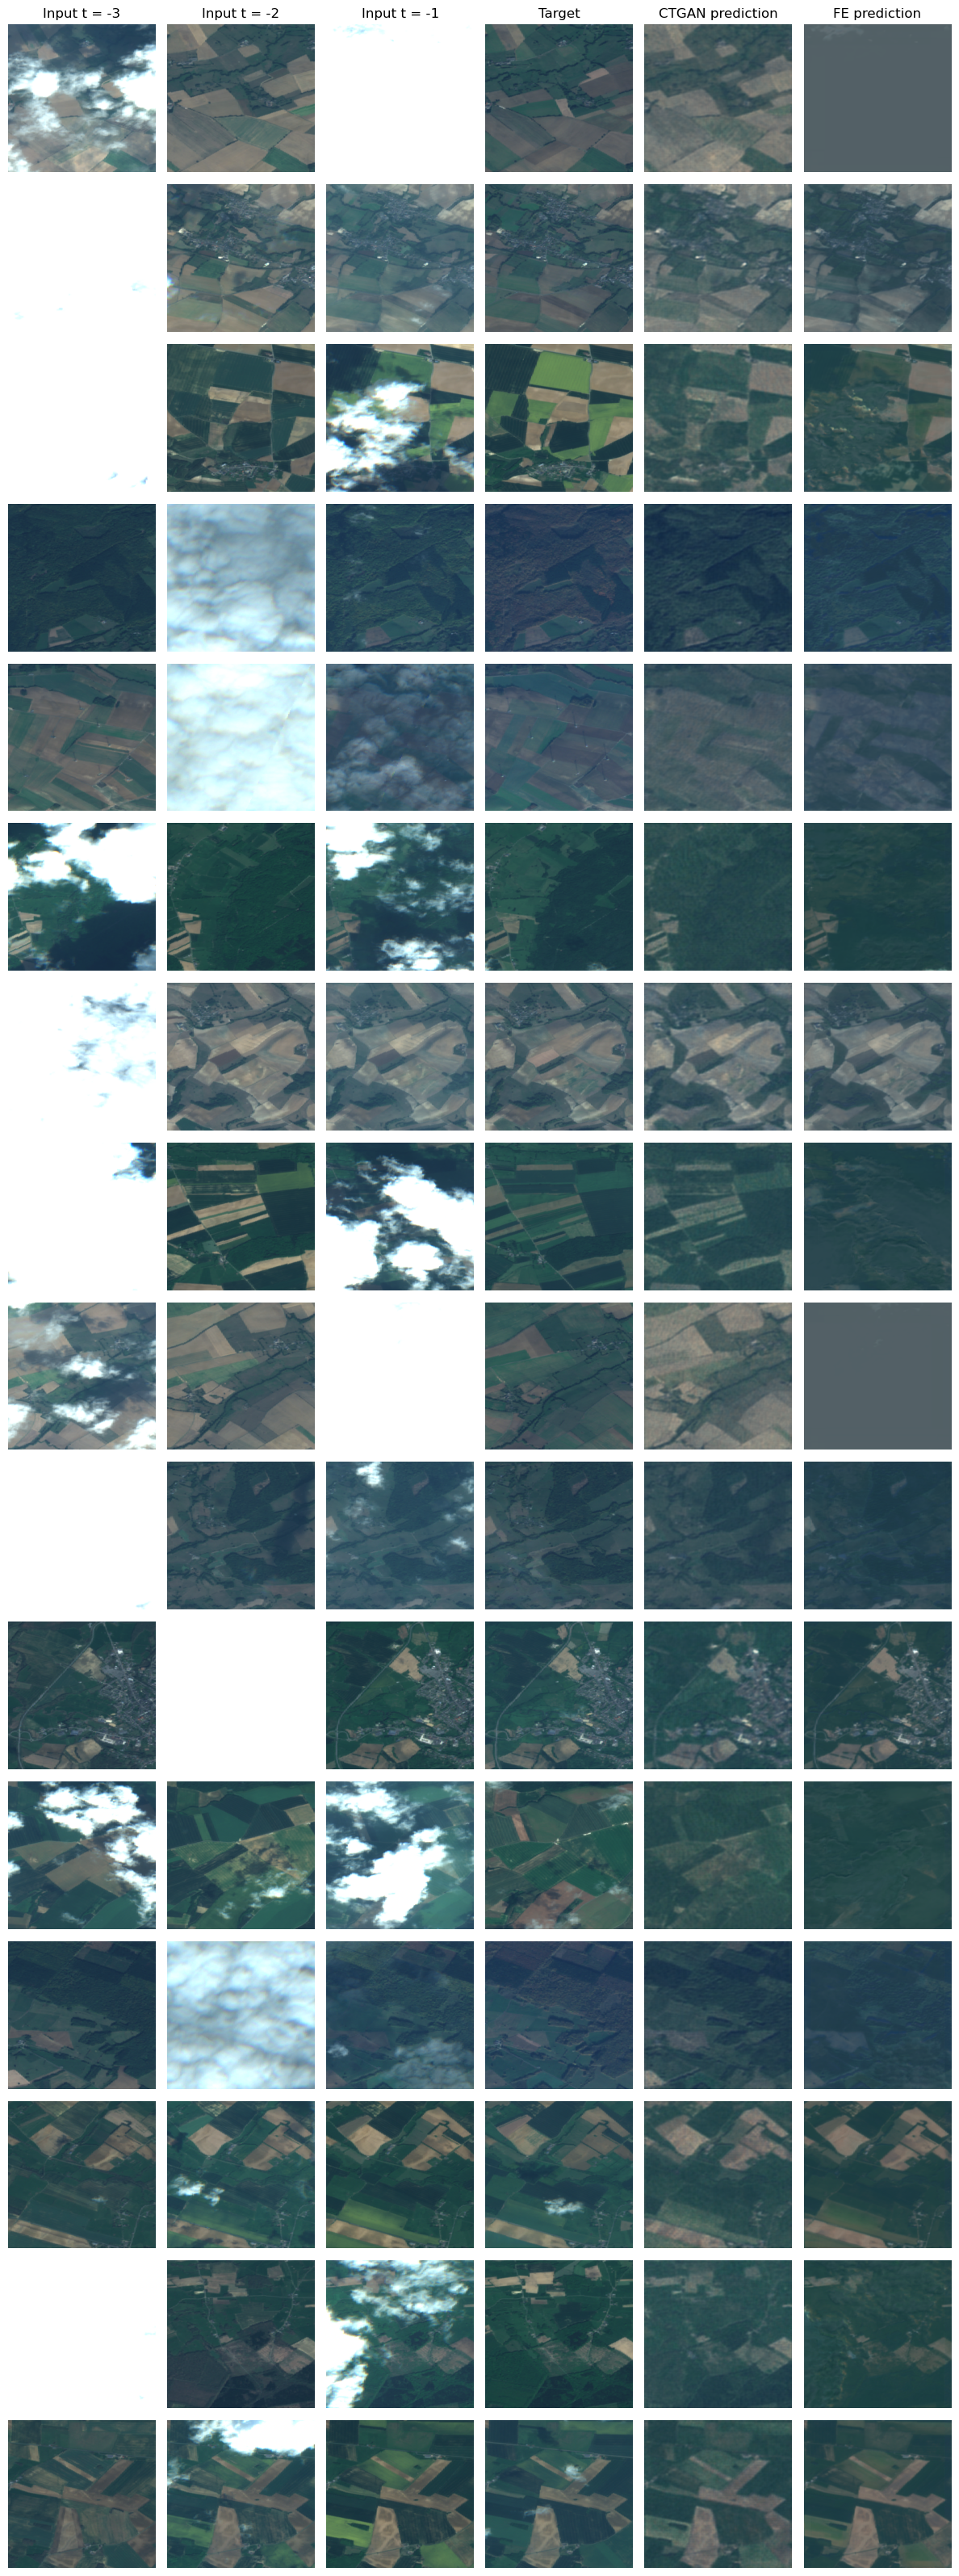

In [47]:
fig, axs = plt.subplots(nrows=16, ncols=6, figsize=(12, 32), tight_layout=True)

for ax in axs.ravel():
    ax.axis("off")

axs[0][0].set_title("Input t = -3")
axs[0][1].set_title("Input t = -2")
axs[0][2].set_title("Input t = -1")
axs[0][3].set_title("Target")
axs[0][4].set_title("CTGAN prediction")
axs[0][5].set_title("FE prediction")


for row in range(16):
    axs[row][0].imshow(rescaled_inputs[2][row, :3].moveaxis(0, -1).detach().cpu() * 0.5 + 0.5)
    axs[row][1].imshow(rescaled_inputs[1][row, :3].moveaxis(0, -1).detach().cpu() * 0.5 + 0.5)
    axs[row][2].imshow(rescaled_inputs[0][row, :3].moveaxis(0, -1).detach().cpu() * 0.5 + 0.5)
    axs[row][3].imshow(rescaled_targets[row, :3].moveaxis(0, -1).detach().cpu() * 0.5 + 0.5)
    axs[row][4].imshow(prediction[row, :3].moveaxis(0, -1).detach().cpu() * 0.5 + 0.5)
    axs[row][5].imshow(pred_0[row, :3].moveaxis(0, -1).detach().cpu() * 0.5 + 0.5)
    
fig.savefig("../images/CTGAN_and_FE_results.png", dpi=160)

plt.show()

### Example evaluation

In [48]:
batch["index"]

tensor([175, 532, 523, 433, 607, 430, 761, 176, 173, 573,  37, 399, 318, 104,
        251, 150])

In [49]:
i = 6

In [50]:
example_index = dataset.data.iloc[batch["index"][i].item()].name
example_index

('ROIs1868', 17, 359, 23)

In [51]:
ssim11_value = ssim(
    prediction[i].detach().cpu().numpy(),
    rescaled_targets[i].detach().cpu().numpy(),
    win_size=11,
    data_range=2.0,
    channel_axis=0
)
ssim51_value = ssim(
    prediction[i].detach().cpu().numpy(),
    rescaled_targets[i].detach().cpu().numpy(),
    win_size=51,
    data_range=2.0,
    channel_axis=0
)
psnr_value = psnr(
    prediction[i].detach().cpu().numpy(),
    rescaled_targets[i].detach().cpu().numpy(),
    data_range=2.0,
)
corr_ndvi_value = np.corrcoef(
    get_ndvi(rescale_s2_back(prediction[i], from_tanh=True)).ravel(),
    get_ndvi(rescale_s2_back(rescaled_targets[i], from_tanh=True)).ravel()
)[0, 1]

ssim11_value, ssim51_value, psnr_value, corr_ndvi_value

(0.6726892, 0.70586616, 25.794919184982867, 0.9174188905636372)

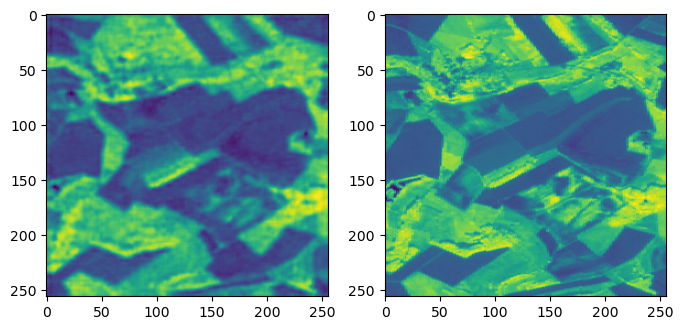

In [52]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
axs[0].imshow(get_ndvi(rescale_s2_back(prediction[i], from_tanh=True)))
axs[1].imshow(get_ndvi(rescale_s2_back(rescaled_targets[i], from_tanh=True)))
plt.show()

# Prepare for validation

In [27]:
from torch.utils.data import DataLoader
from parse import parse

In [28]:
path_to_checkpoints = "/LOCAL2/shvl/checkpoints/CTGAN/SEN12MS-CR-TS/RUN_010"

In [29]:
generator_filenames_schema = "RUN_010_G_step_{step:d}.pth"
generator_filenames_schema_best = 'RUN_010_G_best_{metric}_{step:d}.pth'

training_steps = {}

for filename in generator_filenames:
    parsed_data = parse(generator_filenames_schema, filename)
    if parsed_data is None:
        parsed_data = parse(generator_filenames_schema_best, filename)
    if parsed_data is None:
        print(f"Could not parse {filename}")
        continue
    recovered_step = parsed_data.named["step"]
    if recovered_step < 40000:
        continue
    training_steps[recovered_step] = filename

In [30]:
training_steps = dict(sorted(training_steps.items()))

In [31]:
len(training_steps)

143

In [32]:
training_steps

{40000: 'RUN_010_G_step_40000.pth',
 41000: 'RUN_010_G_step_41000.pth',
 42000: 'RUN_010_G_step_42000.pth',
 42240: 'RUN_010_G_best_SSIM_42240.pth',
 43000: 'RUN_010_G_step_43000.pth',
 43520: 'RUN_010_G_best_SSIM_43520.pth',
 44000: 'RUN_010_G_step_44000.pth',
 45000: 'RUN_010_G_step_45000.pth',
 46000: 'RUN_010_G_step_46000.pth',
 46080: 'RUN_010_G_best_PSNR_46080.pth',
 47000: 'RUN_010_G_step_47000.pth',
 47616: 'RUN_010_G_best_SSIM_47616.pth',
 48000: 'RUN_010_G_step_48000.pth',
 49000: 'RUN_010_G_step_49000.pth',
 49664: 'RUN_010_G_best_PSNR_49664.pth',
 49920: 'RUN_010_G_best_SSIM_49920.pth',
 50000: 'RUN_010_G_step_50000.pth',
 51000: 'RUN_010_G_step_51000.pth',
 52000: 'RUN_010_G_step_52000.pth',
 53000: 'RUN_010_G_step_53000.pth',
 54000: 'RUN_010_G_step_54000.pth',
 54016: 'RUN_010_G_best_SSIM_54016.pth',
 54272: 'RUN_010_G_best_PSNR_54272.pth',
 55000: 'RUN_010_G_step_55000.pth',
 56000: 'RUN_010_G_step_56000.pth',
 57000: 'RUN_010_G_step_57000.pth',
 58000: 'RUN_010_G_step_

In [48]:
BATCH_SIZE = 64

METRICS = ["SSIM-norm-11w", "SSIM-norm-51w", "PSNR-norm", "CORR_NDVI"]
STEPS = training_steps.keys()
SAMPLES = list(range(len(dataset.data)))

In [49]:
STEPS = list(STEPS)[:-11]
STEPS[-1]

152832

In [50]:
try:
    result_df_ctgan = pd.read_csv("CTGAN_full_validation.csv", index_col=["Step", "Sample"])
except FileNotFoundError:
    print("Create new CTGAN results")
    result_df_ctgan = pd.DataFrame(
        0.0,
        index=pd.MultiIndex.from_product(
            [
                STEPS, 
                SAMPLES
            ],
            names=["Step", "Sample"]
        ) ,
        columns=METRICS
    )

try:
    result_df_fe = pd.read_csv("FE_full_validation.csv", index_col=["Step", "Sample"])
except FileNotFoundError:
    print("Create new FE results")
    result_df_fe = pd.DataFrame(
        0.0,
        index=pd.MultiIndex.from_product(
            [
                STEPS, 
                SAMPLES
            ],
            names=["Step", "Sample"]
        ) ,
        columns=METRICS
    )

result_df_fe

SSIM-norm-11w  SSIM-norm-51w  PSNR-norm  CORR_NDVI
Step   Sample                                                    
40000  0            0.000000       0.000000   0.000000   0.000000
       1            0.000000       0.000000   0.000000   0.000000
       2            0.000000       0.000000   0.000000   0.000000
       3            0.000000       0.000000   0.000000   0.000000
       4            0.000000       0.000000   0.000000   0.000000
...                      ...            ...        ...        ...
163000 758          0.642775       0.673280  19.288116   0.830191
       759          0.695948       0.694649  20.427358   0.795889
       760          0.652213       0.686858  26.505938   0.900068
       761          0.545968       0.617138  22.539173   0.908828
       762          0.330134       0.311435  19.276607   0.744346

[109109 rows x 4 columns]

In [51]:
val_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    num_workers=16,
    pin_memory=True,
    drop_last=False,
    shuffle=False
)

In [52]:
batches = []

for batch in tqdm(val_loader):
    
    batch = {
        name: rescale_s2(tensor).to(device=device, dtype=torch.float32, non_blocking=True) if name.startswith("S2_t-") else tensor
        for name, tensor in batch.items()
    }
    batch["index"] = batch["index"].numpy()
    batch["S2_t0"] = batch["S2_t0"].numpy().astype(np.int32)
    batch["S2_t0_rescaled"] = rescale_s2(batch["S2_t0"])
    
    batches.append(batch)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [01:05<00:00,  5.44s/it]


In [57]:
generator = model
generator = generator.to(device)
generator.eval()

for training_step in tqdm(reversed(STEPS)):
    
    model_filename = training_steps[training_step]
    state_dict = torch.load(join(path_to_checkpoints, model_filename), map_location=device)
    state_dict = {key.replace("comformer", "conformer"): value for key, value in state_dict.items()}
    
    generator.load_state_dict(state_dict)

    for batch in batches:
        
        indices = batch["index"]
        inputs = [batch["S2_t-1"], batch["S2_t-2"], batch["S2_t-3"]]
        targets = batch["S2_t0"]
        targets_rescaled = batch["S2_t0_rescaled"]

        with torch.no_grad():
            predictions_ctgan_rescaled, [_, _, _], [predictions_fe_rescaled, _, _] = generator(inputs)

        predictions_ctgan_rescaled = predictions_ctgan_rescaled.detach().cpu().numpy()
        predictions_fe_rescaled = predictions_fe_rescaled.detach().cpu().numpy()

        for index, prediction_ctgan_rescaled, prediction_fe_rescaled, target, target_rescaled in zip(indices, predictions_ctgan_rescaled, predictions_fe_rescaled, targets, targets_rescaled):
    
            for result_df, prediction_rescaled in [[result_df_fe, prediction_fe_rescaled], [result_df_ctgan, prediction_ctgan_rescaled]]:
            
                ssim11_value = ssim(
                    prediction_rescaled,
                    target_rescaled,
                    win_size=11,
                    data_range=2.0,
                    channel_axis=0
                )
                ssim51_value = ssim(
                    prediction_rescaled,
                    target_rescaled,
                    win_size=51,
                    data_range=2.0,
                    channel_axis=0
                )
                psnr_value = psnr(
                    prediction_rescaled,
                    target_rescaled,
                    data_range=2.0,
                )
                corr_ndvi_value = np.corrcoef(
                    get_ndvi(rescale_s2_back(prediction_rescaled, from_tanh=True)).ravel(),
                    get_ndvi(target[[3, 2, 1, 7]]).ravel()
                )[0, 1]
            
                result_df.loc[(training_step, index)] = ssim11_value, ssim51_value, psnr_value, corr_ndvi_value

    result_df_ctgan.to_csv("CTGAN_full_validation.csv")
    result_df_ctgan.to_csv("FE_full_validation.csv")

132it [3:43:35, 101.63s/it]


# Visualize results

In [65]:
import seaborn as sns

In [88]:
result_df_fe = pd.read_csv("FE_full_validation.csv", index_col=["Step", "Sample"])
result_df_ctgan = pd.read_csv("CTGAN_full_validation.csv", index_col=["Step", "Sample"])

In [101]:
result_df_fe

SSIM-norm-11w  SSIM-norm-51w  PSNR-norm  CORR_NDVI
Step   Sample                                                    
40000  0            0.727919       0.711204  22.658517   0.904107
       1            0.519815       0.451399  16.017717   0.536547
       2            0.771864       0.806841  24.397972   0.926695
       3            0.448624       0.342541  17.923077   0.473286
       4            0.804636       0.828294  23.920824   0.870514
...                      ...            ...        ...        ...
163000 758          0.697010       0.682899  19.762802   0.855357
       759          0.727587       0.695067  19.372930   0.791998
       760          0.662369       0.652587  26.688120   0.927884
       761          0.720722       0.682195  26.161210   0.933124
       762          0.604383       0.532160  21.504258   0.830730

[109109 rows x 4 columns]

In [102]:
# drop last step since it is faulty
result_df_fe = result_df_fe.loc[:162000]
result_df_ctgan = result_df_ctgan.loc[:162000]

In [121]:
result_df_ctgan.groupby("Step").mean().idxmax()

SSIM-norm-11w    137000
SSIM-norm-51w    159000
PSNR-norm        148000
CORR_NDVI        139520
dtype: int64

In [122]:
best_step_ctgan = result_df_ctgan.groupby("Step").mean().idxmax()["SSIM-norm-51w"]
best_step_ctgan

159000

In [125]:
result_df_fe.groupby("Step").mean().idxmax()

SSIM-norm-11w    119000
SSIM-norm-51w    118000
PSNR-norm        118000
CORR_NDVI        139520
dtype: int64

In [132]:
best_step_fe = result_df_fe.groupby("Step").mean().idxmax()["SSIM-norm-51w"]
best_step_fe

118000

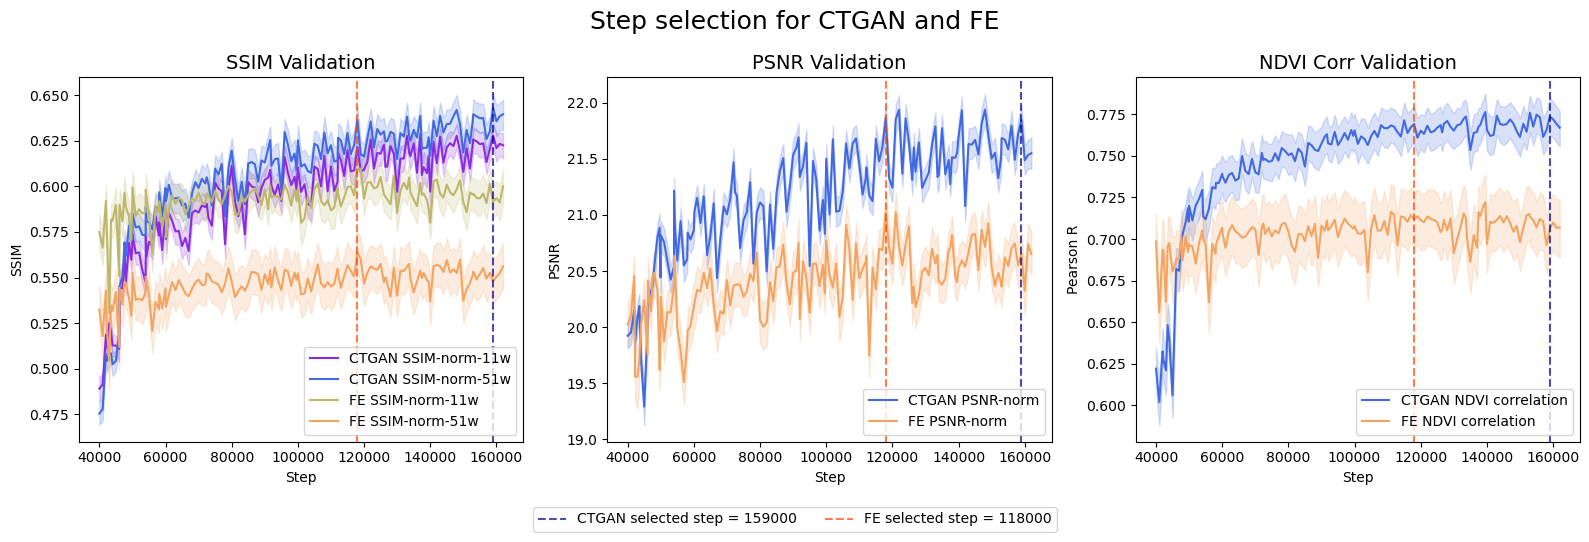

In [150]:
fig, axs = plt.subplots(ncols=3, figsize=(16, 5), tight_layout=True, sharex=True)

fig.suptitle("Step selection for CTGAN and FE", fontsize=18)

# CTGAN

sns.lineplot(data=result_df_ctgan.reset_index(), x="Step", y="SSIM-norm-11w", ax=axs[0], label="CTGAN SSIM-norm-11w", color="blueviolet")
sns.lineplot(data=result_df_ctgan.reset_index(), x="Step", y="SSIM-norm-51w", ax=axs[0], label="CTGAN SSIM-norm-51w", color="royalblue")
axs[0].set_xlabel("Step")
axs[0].set_ylabel("SSIM")
axs[0].set_title("SSIM Validation", fontsize=14)

sns.lineplot(data=result_df_ctgan.reset_index(), x="Step", y="PSNR-norm", ax=axs[1], label="CTGAN PSNR-norm", color="royalblue")
axs[1].set_xlabel("Step")
axs[1].set_ylabel("PSNR")
axs[1].set_title("PSNR Validation", fontsize=14)

sns.lineplot(data=result_df_ctgan.reset_index(), x="Step", y="CORR_NDVI", ax=axs[2], label="CTGAN NDVI correlation", color="royalblue")
axs[2].set_xlabel("Step")
axs[2].set_ylabel("Pearson R")
axs[2].set_title("NDVI Corr Validation", fontsize=14)

# Feature Extractor

sns.lineplot(data=result_df_fe.reset_index(), x="Step", y="SSIM-norm-11w", ax=axs[0], label="FE SSIM-norm-11w", color="darkkhaki")
sns.lineplot(data=result_df_fe.reset_index(), x="Step", y="SSIM-norm-51w", ax=axs[0], label="FE SSIM-norm-51w", color="sandybrown")
line_ctgan = axs[0].axvline(best_step_ctgan, color="darkblue", linestyle="dashed", alpha=0.7)
line_fe = axs[0].axvline(best_step_fe, color="orangered", linestyle="dashed", alpha=0.7)
axs[0].legend(loc="lower right")

sns.lineplot(data=result_df_fe.reset_index(), x="Step", y="PSNR-norm", ax=axs[1], label="FE PSNR-norm", color="sandybrown")
axs[1].axvline(best_step_ctgan, color="darkblue", linestyle="dashed", alpha=0.7)
axs[1].axvline(best_step_fe, color="orangered", linestyle="dashed", alpha=0.7)
axs[1].legend(loc="lower right")

sns.lineplot(data=result_df_fe.reset_index(), x="Step", y="CORR_NDVI", ax=axs[2], label="FE NDVI correlation", color="sandybrown")
axs[2].axvline(best_step_ctgan, color="darkblue", linestyle="dashed", alpha=0.7)
axs[2].axvline(best_step_fe, color="orangered", linestyle="dashed", alpha=0.7)
axs[2].legend(loc="lower right")

# Figure legend
# axs[0].axvline(best_step_ctgan, color="darkblue", linestyle="dashed", label=f"CTGAN best step = {best_step_ctgan}", alpha=1)
# axs[0].axvline(best_step_fe, color="orangered", linestyle="dashed", label=f"FE best step = {best_step_fe}", alpha=1)
fig.legend(handles=[line_ctgan, line_fe], labels=[f"CTGAN selected step = {best_step_ctgan}", f"FE selected step = {best_step_fe}"], loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=2)

fig.savefig("../images/Step_selection_CTGAN_FE.png", dpi=160)
plt.show()

# Load best model

In [49]:
best_step = 117000

In [50]:
from os.path import join
from CTGAN.train import Trainer
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch

In [51]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from CTGAN.model.CTGAN import CTGAN_Generator

In [52]:
from torch.utils.data import DataLoader

In [53]:
path_to_checkpoints = "/LOCAL2/shvl/checkpoints/CTGAN/SEN12MS-CR-TS/RUN_010"
generator_filenames_schema = "RUN_010_G_step_{step:d}.pth"
best_checkpoint = generator_filenames_schema.format(step=best_step)
path_to_checkpoint = join(path_to_checkpoints, best_checkpoint)

In [54]:
state_dict = {key.replace("comformer", "conformer"): value for key, value in torch.load(path_to_checkpoint, map_location=device).items()}

In [55]:
model = CTGAN_Generator(image_size=256)

In [56]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [57]:
model = model.to(device)

In [58]:
_ = model.eval()

In [106]:
dataset = CTGAN_S2_Dataset(
    dataset_manager, 
    min_target_area=0.95, 
    min_inputs_area=0.5, 
    rescale=False,
    filter_bands=False,
    include_index=True,
    include_cloudmaps=False
)
len(dataset)

156684

In [107]:
dataset_val = dataset.subset(s1_resampled=True, split="val", inplace=False)
dataset_test = dataset.subset(s1_resampled=True, split="test", inplace=False)
dataset.data = pd.concat([dataset_val.data, dataset_test.data], join="outer", axis=0)
del dataset_val
del dataset_test

len(dataset)

36293

In [108]:
val_loader = DataLoader(
    dataset,
    batch_size=2,
    num_workers=0,
    pin_memory=True,
    drop_last=False,
    shuffle=False
)

In [109]:
test_iterator = iter(val_loader)
test_batch = next(test_iterator)

In [110]:
batch = {
    name: tensor.to(device=device, dtype=torch.float32, non_blocking=True)
    for name, tensor in batch.items()
}
inputs = [batch["S2_t-1"], batch["S2_t-2"], batch["S2_t-3"]]
inputs = [rescale_s2(image) for image in inputs]

In [111]:
with torch.no_grad():
    test_prediction, _, _ = model(inputs)

test_prediction.shape

torch.Size([2, 4, 256, 256])

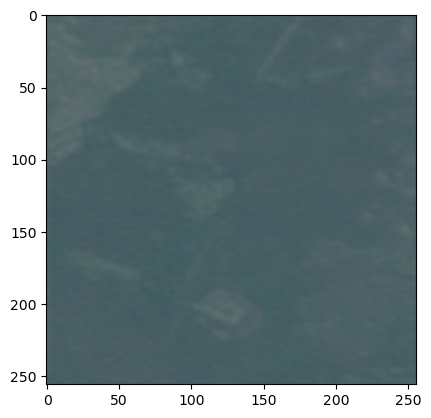

In [112]:
plt.imshow(test_prediction[0, :3].moveaxis(0, -1).detach().cpu())
plt.show()

In [116]:
metrics = pd.DataFrame(
    0.0,
    index=dataset.data.index,
    columns=["SSIM11", "SSIM51", "PSNR", "SSIM11_10K", "SSIM51_10K", "PSNR_10K"]
)
metrics

SSIM11  SSIM51  PSNR  SSIM11_10K  SSIM51_10K  \
ROI      tile patch timestep                                                 
ROIs1868 17   0     4            0.0     0.0   0.0         0.0         0.0   
                    10           0.0     0.0   0.0         0.0         0.0   
                    23           0.0     0.0   0.0         0.0         0.0   
                    26           0.0     0.0   0.0         0.0         0.0   
              1     4            0.0     0.0   0.0         0.0         0.0   
...                              ...     ...   ...         ...         ...   
ROIs2017 140  269   21           0.0     0.0   0.0         0.0         0.0   
                    22           0.0     0.0   0.0         0.0         0.0   
                    24           0.0     0.0   0.0         0.0         0.0   
                    26           0.0     0.0   0.0         0.0         0.0   
                    28           0.0     0.0   0.0         0.0         0.0   

                              PSNR_10K  
ROI      tile patch timestep            
ROIs1868 17   0     4              0.0  
                    10             0.0  
                    23             0.0  
                    26             0.0  
              1     4              0.0  
...                                ...  
ROIs2017 140  269   21             0.0  
                    22             0.0  
                    24             0.0  
                    26             0.0  
                    28             0.0  

[36293 rows x 6 columns]

In [120]:
val_loader = DataLoader(
    dataset,
    batch_size=32,
    num_workers=16,
    pin_memory=True,
    drop_last=False,
    shuffle=False
)

In [121]:
from spatiotemporal.imagefile import ImageFile
from os import makedirs
from osgeo import gdal

save_tif = dataset_manager.utils.save_tif_fast
path_to_predictions = join("/LOCAL2/shvl/predictions/CTGAN/SEN12MS-CR-TS/RUN_010", best_checkpoint[:-4])
BANDS = [3, 2, 1, 7]

In [122]:
generator = model

for step, batch in enumerate(tqdm(val_loader)):
    
    batch = {
        name: tensor.to(device=device, dtype=torch.float32, non_blocking=True)
        if not name == "index" else tensor
        for name, tensor in batch.items()
    }
    
    s2_filepaths = dataset.data.iloc[batch["index"].numpy()][(0, "S2")]

    inputs = [batch["S2_t-1"], batch["S2_t-2"], batch["S2_t-3"]]
    inputs = [rescale_s2(image) for image in inputs]
    target = batch["S2_t0"]
    rescaled_target = legacy_rescale_s2(target, old_version=False)  # Both target and output are in range [0..1]

    with torch.no_grad():
        prediction, [att0, att1, att2], [pred_0, pred_1, pred_2] = generator(inputs)
    
    for index, prediction_image, rescaled_target_image, target_image in zip(batch["index"], prediction, rescaled_target, target):

        # save rescaled metrics in [0..1] value range

        metrics.loc[metrics.index[index], "SSIM11"] = ssim(
            prediction_image.cpu().numpy(),
            rescaled_target_image.cpu().numpy(),
            win_size=11,
            data_range=1.0,
            channel_axis=0
        )
        metrics.loc[metrics.index[index], "SSIM51"] = ssim(
            prediction_image.cpu().numpy(),
            rescaled_target_image.cpu().numpy(),
            win_size=51,
            data_range=1.0,
            channel_axis=0
        )
        metrics.loc[metrics.index[index], "PSNR"] = psnr(
            prediction_image.cpu().numpy(),
            rescaled_target_image.cpu().numpy(),
            data_range=1.0,
        )

        s2_filepath = dataset.data.iloc[index.item()][(0, "S2")]

        unrescaled_prediction_image = rescale_s2_back(prediction_image)
        outfile = ImageFile(s2_filepath)
        outfile = outfile.set(root_dir=path_to_predictions)
        makedirs(outfile.directory, exist_ok=True)

        # Un-rescaled back to [0..10000]
        save_tif(
            target_path=outfile.filepath,
            output_image=unrescaled_prediction_image,
            path_to_donor_image=s2_filepath,
            gdal_dtype=gdal.GDT_UInt16
        )

        metrics.loc[metrics.index[index], "SSIM11_10K"] = ssim(
            unrescaled_prediction_image,
            target_image[BANDS].cpu().numpy(),
            win_size=11,
            data_range=10000,
            channel_axis=0
        )
        metrics.loc[metrics.index[index], "SSIM51_10K"] = ssim(
            unrescaled_prediction_image,
            target_image[BANDS].cpu().numpy(),
            win_size=51,
            data_range=10000,
            channel_axis=0
        )
        metrics.loc[metrics.index[index], "PSNR_10K"] = psnr(
            unrescaled_prediction_image,
            target_image[BANDS].cpu().numpy(),
            data_range=10000,
        )

    if step % 100:
        metrics.to_csv("CTGAN_metrics_per_image.csv")


    

100%|█████████████████████████████████████| 1135/1135 [1:33:15<00:00,  4.93s/it]


In [124]:
metrics.to_csv("CTGAN_metrics_per_image.csv")

# Run feature extractor

In [65]:
from CTGAN.datasets.s2_dataset import CTGAN_S2_Dataset
from torch.utils.data import DataLoader
from CTGAN.model.CTGAN import CTGAN_Generator
from tqdm import tqdm

In [7]:
dataset = CTGAN_S2_Dataset(
    dataset_manager, 
    min_target_area=0.95, 
    min_inputs_area=0.5,
    rescale=False,
    filter_bands=False,
    include_index=True,
    include_cloudmaps=False,
    include_cloud_cover=True
)
len(dataset)

156684

In [8]:
dataset_val = dataset.subset(s1_resampled=True, split="val", inplace=False)
dataset_test = dataset.subset(s1_resampled=True, split="test", inplace=False)
dataset.data = pd.concat([dataset_val.data, dataset_test.data], join="outer", axis=0)
del dataset_val
del dataset_test

len(dataset)

36293

In [64]:
val_loader = DataLoader(
    dataset,
    batch_size=1,
    num_workers=16,
    pin_memory=True,
    drop_last=False,
    shuffle=False
)

In [71]:
fe_metrics = pd.DataFrame(
    0.0,
    index=dataset.data.index,
    columns=["SSIM11", "SSIM51", "PSNR", "SSIM11_10K", "SSIM51_10K", "PSNR_10K"]
)
fe_metrics

SSIM11  SSIM51  PSNR  SSIM11_10K  SSIM51_10K  \
ROI      tile patch timestep                                                 
ROIs1868 17   0     4            0.0     0.0   0.0         0.0         0.0   
                    10           0.0     0.0   0.0         0.0         0.0   
                    23           0.0     0.0   0.0         0.0         0.0   
                    26           0.0     0.0   0.0         0.0         0.0   
              1     4            0.0     0.0   0.0         0.0         0.0   
...                              ...     ...   ...         ...         ...   
ROIs2017 140  269   21           0.0     0.0   0.0         0.0         0.0   
                    22           0.0     0.0   0.0         0.0         0.0   
                    24           0.0     0.0   0.0         0.0         0.0   
                    26           0.0     0.0   0.0         0.0         0.0   
                    28           0.0     0.0   0.0         0.0         0.0   

                              PSNR_10K  
ROI      tile patch timestep            
ROIs1868 17   0     4              0.0  
                    10             0.0  
                    23             0.0  
                    26             0.0  
              1     4              0.0  
...                                ...  
ROIs2017 140  269   21             0.0  
                    22             0.0  
                    24             0.0  
                    26             0.0  
                    28             0.0  

[36293 rows x 6 columns]

In [72]:
from spatiotemporal.imagefile import ImageFile
from os import makedirs
from osgeo import gdal

save_tif = dataset_manager.utils.save_tif_fast
path_to_predictions = join("/LOCAL2/shvl/predictions/CTGAN_FEATURE_EXTRACTOR/RUN_010", best_checkpoint[:-4])
BANDS = [3, 2, 1, 7]

In [79]:
for batch in tqdm(val_loader):

    with torch.no_grad():
    
        index = batch["index"].item()
    
        target_image = batch["S2_t0"][0]
        rescaled_target_image = legacy_rescale_s2(target_image, old_version=False).detach().cpu().numpy()
        target_image = target_image[BANDS].detach().cpu().numpy()
    
        best_t = None
        best_cloudfree_area = 0.0
        for t in [-1, -2, -3]:
            if batch[f"CLOUDFREEAREA_t{t}"].item() > best_cloudfree_area + 0.01:
                best_cloudfree_area = batch[f"CLOUDFREEAREA_t{t}"].item()
                best_t = t
        
        input_image = rescale_s2(batch[f"S2_t{best_t}"])
    
        
        _, _, prediction = feature_extractor(input_image.to(device))
        
    
        prediction = prediction.detach().cpu().numpy()[0]
        unrescaled_prediction = rescale_s2_back(prediction)
    
        s2_filepath = dataset.data.iloc[batch["index"].item()][(0, "S2")]
    
        outfile = ImageFile(s2_filepath)
        outfile = outfile.set(root_dir=path_to_predictions)
        makedirs(outfile.directory, exist_ok=True)
    
        fe_metrics.loc[fe_metrics.index[index], "SSIM11"] = ssim(
            prediction,
            rescaled_target_image,
            win_size=11,
            data_range=1.0,
            channel_axis=0
        )
        fe_metrics.loc[fe_metrics.index[index], "SSIM51"] = ssim(
            prediction,
            rescaled_target_image,
            win_size=51,
            data_range=1.0,
            channel_axis=0
        )
        fe_metrics.loc[fe_metrics.index[index], "PSNR"] = psnr(
            prediction,
            rescaled_target_image,
            data_range=1.0,
        )
    
        # Un-rescaled back to [0..10000]
        save_tif(
            target_path=outfile.filepath,
            output_image=unrescaled_prediction,
            path_to_donor_image=s2_filepath,
            gdal_dtype=gdal.GDT_UInt16
        )
    
        fe_metrics.loc[fe_metrics.index[index], "SSIM11_10K"] = ssim(
            unrescaled_prediction,
            target_image,
            win_size=11,
            data_range=10000,
            channel_axis=0
        )
        fe_metrics.loc[fe_metrics.index[index], "SSIM51_10K"] = ssim(
            unrescaled_prediction,
            target_image,
            win_size=51,
            data_range=10000,
            channel_axis=0
        )
        fe_metrics.loc[fe_metrics.index[index], "PSNR_10K"] = psnr(
            unrescaled_prediction,
            target_image,
            data_range=10000,
        )

100%|█████████████████████████████████████| 36293/36293 [45:03<00:00, 13.42it/s]


In [80]:
fe_metrics.to_csv("CTGAN_Feature_Extractor_metrics_per_image.csv")